# Offenive evolution of LeBron James in NBA
In this notebook we present an analysis of the evolution of LeBron James' offensive game, in terms of shot selection and efficiency, over the course of his NBA career. In particular, we analyze data from the regular seasons from 2003-2004 to 2019-2020, with the aim of understanding how his game has changed over the years and how this has influenced the offensive production of his teams.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# NBA Court Chart
First, we need to define the NBA court chart, which will be used to plot the shot data. The following code defines a function that generates a basketball court chart using the matplotlib library. The function takes as input the axis object on which the court will be plotted and the color of the court lines. The function then plots the court lines and returns the axis object for further customization.
This function is a modified version of the one provided by Zach Gilbert in his project "Visualizing NBA Shots with py-Goldsberry" which can be found here https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb.

In [2]:
#NBA COURT CHART
#Reference: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
#NBA court dimensions: https://official.nba.com/rule-no-1-court-dimensions-equipment/
#le dimensioni del campo sono tradotte nell'unità di misura del sistema di riferimento del grafico

#PARAMETRI DEL CAMPO
color = 'black'
lw = 2

def draw_court(ax=None):
        
    ax = plt.gca()

    # CREATE THE ELEMENTS OF THE COURT
    # Create the basketball hoop
    hoop = patches.Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = patches.Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # Create the paint
    
    paint_lines = patches.Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
    
    # Create free throw top arc
    free_throw = patches.Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
    
    # Create restricted area
    restricted_area = patches.Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)

    # Create three point lines
    #side 3pt lines
    right_corner_side_line = patches.Rectangle((-220, -47.5), 0, 137.5, linewidth=lw, color=color)
    left_corner_side_line = patches.Rectangle((220, -47.5), 0, 137.5, linewidth=lw, color=color)

    # 3pt arc
    three_arc = patches.Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)


    # List of the court elements to be plotted onto the axes

    outer_lines = patches.Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)

    # Add the court elements onto the axes
    court_elements = [hoop, backboard, paint_lines, free_throw, restricted_area, right_corner_side_line, left_corner_side_line, three_arc, outer_lines]

    for element in court_elements:
        ax.add_patch(element)

    return ax


# Area Chart
Once we have defined the court chart, we can implement a new function that generates the areas in which a court is divided. To be more specific, we will divide the court into 10 areas:
- Restricted Area
- In The Paint (Non-RA)
- Mid-Range Left
- Mid-Range Right
- Mid-Range Center
- Left Corner 3
- Right Corner 3
- Three Point Left
- Three Point Right
- Thre Point Center

This function utilizes Polygon objects from the shapely library to define specific areas. We start by constructing several polygons using the coordinates of the points that define the vertices of these areas. Then, we employ set operations on these polygons to create the desired areas.
The function returns a dictionary that maps each area to its corresponding polygon object.


In [29]:
from shapely.geometry import Polygon

# Creare l'arco da tre punti
theta = np.linspace(np.radians(22), np.radians(158), 100)
arc_x = 237.5 * np.cos(theta)
arc_y = 237.5 * np.sin(theta)


# Creare la restricted area
theta = np.linspace(np.radians(0), np.radians(180), 100)
restricted_x = 40 * np.cos(theta)
restricted_y = 40 * np.sin(theta)

# DEFINIZIONE DEI PUNTI DELLE DIVERSE AREE DI TIRO
# Arco da tre punti
Arc_points = np.column_stack((arc_x, arc_y))

# Tiro da tre punti
ThreePointArea_Left_points = [(250, 422.5), (250, 90), (220, 90), (80, 142.5), (120, 422.5)]

ThreePointArea_Center_points = [(80, 142.5), (120, 422.5), (-120, 422.5), (-80, 142.5)]

ThreePointArea_Right_points = [(-250, 422.5), (-250, 90), (-220, 90), (-80, 142.5), (-120, 422.5)]

# Tiro da tre punti (angoli)
LeftCornerThree_points = [(220, -47.5), (220, 90), (250, 90), (250, -47.5)]

RightCornerThree_points = [(-220, -47.5), (-220, 90), (-250, 90), (-250, -47.5)]


# Mid Range
MidRange_Left_points_Aux = [(120, 422.5), (80, 142.5), (80, -47.5), (220, -47.5), (220, 422.5)]
MidRange_Center_points = [(-80, 142.5), (-120, 422.5), (120, 422.5), (80, 142.5)]
MidRange_Right_points_Aux = [(-120, 422.5), (-80, 142.5), (-80, -47.5), (-220, -47.5), (-220, 422.5)]

# Pitturato
Paint_points = [(80, -47.5), (80, 142.5), (-80, 142.5), (-80, -47.5)]

# Restricted Area
#Aggiungo i punti per un rettangolo tra la restricheted area e il tabellone
Restricted_Area_points1 = np.column_stack((restricted_x, restricted_y))
Restriced_Area_points2 = [(40, 0), (40, -10), (-40, -10), (-40, 0)]
Restricted_Area_points = np.vstack((Restricted_Area_points1, Restriced_Area_points2))


# CREAZIONE DEGLI OGGETTI POLYGON
def create_polygons():

# Arco da tre punti
# Oggetto ausiliario per costruire i diversi poligoni da plottare
    Arc_Pol = Polygon(Arc_points)

    # Tiro da tre punti
    ThreePointArea_Left_Aux = Polygon(ThreePointArea_Left_points)
    ThreePointArea_Center_Aux = Polygon(ThreePointArea_Center_points)
    ThreePointArea_Right_Aux = Polygon(ThreePointArea_Right_points)
    LeftCornerThree = Polygon(LeftCornerThree_points)
    RightCornerThree = Polygon(RightCornerThree_points)

    # Mid Range
    MidRange_Left_Aux = Polygon(MidRange_Left_points_Aux)
    MidRange_Center_Aux = Polygon(MidRange_Center_points)
    MidRange_Right_Aux = Polygon(MidRange_Right_points_Aux)

    # Pitturato
    Paint = Polygon(Paint_points)

    # Restricted Area
    Restricted_Area = Polygon(Restricted_Area_points)


    # CALCOLO DELLA DIFFERENZA TRA I POLYGON

    # Tiro da tre punti
    ThreePointArea_Left = ThreePointArea_Left_Aux.difference(Arc_Pol)
    ThreePointArea_Center = ThreePointArea_Center_Aux.difference(Arc_Pol)
    ThreePointArea_Right = ThreePointArea_Right_Aux.difference(Arc_Pol)

    # Mid Range
    MidRange_Center_Aux1 = MidRange_Center_Aux.difference(ThreePointArea_Center)
    MidRange_Center = MidRange_Center_Aux1.difference(Paint)
    MidRange_Left = MidRange_Left_Aux.difference(ThreePointArea_Left)
    MidRange_Right = MidRange_Right_Aux.difference(ThreePointArea_Right)

    # Creazione di un dizionario con i poligoni
    areas = {'ThreePointArea_Left': ThreePointArea_Left, 'ThreePointArea_Center': ThreePointArea_Center,
                      'ThreePointArea_Right': ThreePointArea_Right, 'LeftCornerThree': LeftCornerThree,
                      'RightCornerThree': RightCornerThree, 'MidRange_Left': MidRange_Left, 'MidRange_Center': MidRange_Center,
                      'MidRange_Right': MidRange_Right, 'Paint': Paint, 'Restricted_Area': Restricted_Area}

    return areas

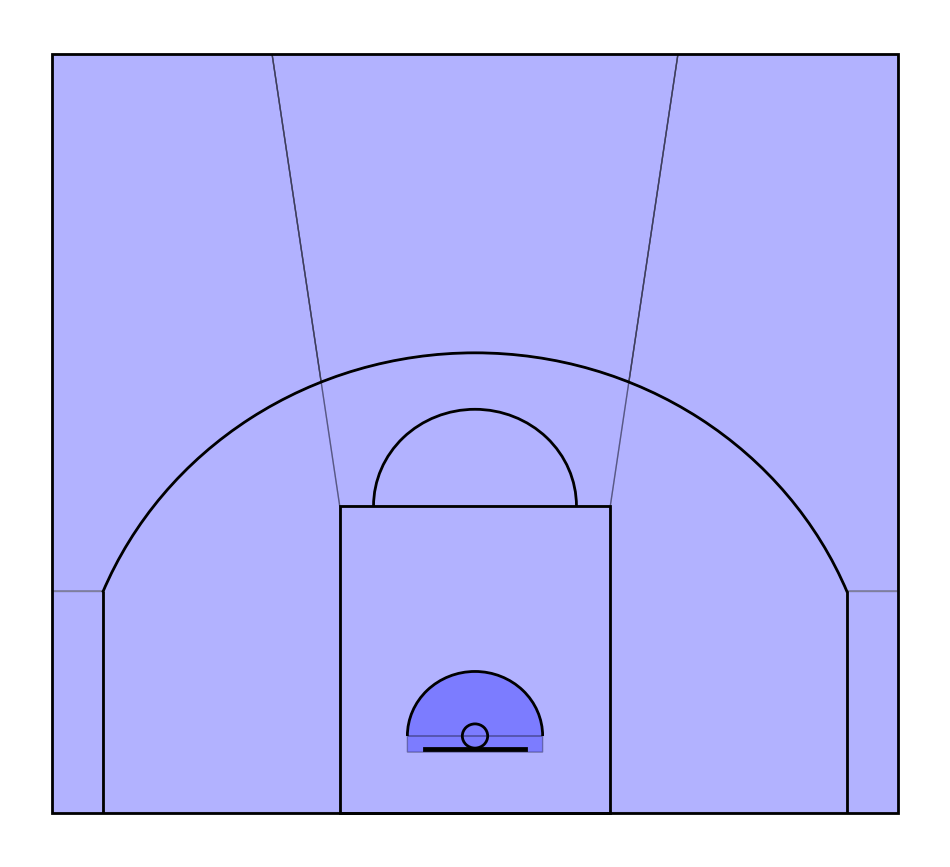

In [30]:
fig, ax = plt.subplots(figsize=(12, 11))

create_polygons()
for area in create_polygons().values():
    plt.fill(*area.exterior.xy, color='blue', alpha=0.3, zorder=0, edgecolor='black')

draw_court(ax=ax)

plt.xlim(-275, 275)
plt.ylim(-75, 450)
plt.axis('off')
plt.show()

In [4]:
# Read in the data
df = pd.read_pickle("LeBronShots.pickle")


Aggiunta dei tiri di Lebron nel periodo compreso tra la stagione 2003-04 e la stagione 2009-10 (inclusa)

In [5]:
Seasons = ['2003-04', '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10']
# rappresento la percentuale di tiri presi in ogni zona del campo, divisi per Area e zona
# il campo è diviso in Left Side, Right Side, , Center, ognuna di queste è divisa in tMid-Range, In The Paint (Non Restricted), Restricted Area, Above the Break 3, Corner 3


# Prendo l'insieme zona e area dal dataset e calcolo la percentuale di tiri presi in ogni zona rispetto al totale

#calcolo il totale dei tiri presi in ogni zona
#Left Side Mid-Range
LS_Mid = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]


#Left Side Above the Break 3
LS_Above = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Left Side Corner 3
LS_Corner = df[(df.Zone == 'Left Corner 3') & (df.SEASON.isin(Seasons))].shape[0]



#Right Side Mid-Range
RS_Mid = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]

#Right Side Above the Break 3
RS_Above = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Right Side Corner 3
RS_Corner = df[(df.Zone == 'Right Corner 3') & (df.SEASON.isin(Seasons))].shape[0]


#Center Mid-Range
C_Mid = df[(df.Area == 'Center(C)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]

#In The Paint (Non Restricted)
Paint = df[(df.Zone == 'In The Paint (Non-RA)') & (df.SEASON.isin(Seasons))].shape[0]

#Restricted Area
Restricted = df[(df.Zone == 'Restricted Area') & (df.SEASON.isin(Seasons))].shape[0]

#Center Above the Break 3
C_Above = df[(df.Area == 'Center(C)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]



total = df[df.SEASON.isin(Seasons)].shape[0]
lS_Mid_Perc = LS_Mid / total * 100
lS_Above_Perc = LS_Above / total * 100
lS_Corner_Perc = LS_Corner / total * 100

rS_Mid_Perc = RS_Mid / total * 100
rS_Above_Perc = RS_Above / total * 100
rS_Corner_Perc = RS_Corner / total * 100

c_Mid_Perc = C_Mid / total * 100
restricted_Perc = Restricted / total * 100
paint_Perc = Paint / total * 100
c_Above_Perc = C_Above / total * 100

print('Left Side Mid-Range:', lS_Mid_Perc)
print('Left Side Above the Break 3:', lS_Above_Perc)
print('Left Side Corner 3:', lS_Corner_Perc)

print('Right Side Mid-Range:', rS_Mid_Perc)
print('Right Side Above the Break 3:', rS_Above_Perc)
print('Right Side Corner 3:', rS_Corner_Perc)

print('Center Mid-Range:', c_Mid_Perc)
print('Restricted Area:', restricted_Perc)
print('In The Paint (Non Restricted):', paint_Perc)
print('Center Above the Break 3:', c_Above_Perc)

Left Side Mid-Range: 15.219244246614263
Left Side Above the Break 3: 6.790415759068094
Left Side Corner 3: 1.5910597594469174
Right Side Mid-Range: 15.219244246614263
Right Side Above the Break 3: 5.805474003220002
Right Side Corner 3: 1.6857656975092339
Center Mid-Range: 3.9492376171985986
Restricted Area: 35.34425608485652
In The Paint (Non Restricted): 10.256653092148877
Center Above the Break 3: 3.854531679136282


In [6]:
Seasons = ['2010-11', '2011-12', '2012-13', '2013-14']
# rappresento la percentuale di tiri presi in ogni zona del campo, divisi per Area e zona
# il campo è diviso in Left Side, Right Side, , Center, ognuna di queste è divisa in tMid-Range, In The Paint (Non Restricted), Restricted Area, Above the Break 3, Corner 3


# Prendo l'insieme zona e area dal dataset e calcolo la percentuale di tiri presi in ogni zona rispetto al totale


#calcolo il totale dei tiri presi in ogni zona
#Left Side Mid-Range
LS_Mid = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]


#Left Side Above the Break 3
LS_Above = df[(df.Area == 'Left Side(L)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Left Side Corner 3
LS_Corner = df[(df.Zone == 'Left Corner 3') & (df.SEASON.isin(Seasons))].shape[0]


#Right Side Mid-Range
RS_Mid = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]



#Right Side Above the Break 3
RS_Above = df[(df.Area == 'Right Side(R)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

#Right Side Corner 3
RS_Corner = df[(df.Zone == 'Right Corner 3') & (df.SEASON.isin(Seasons))].shape[0]


#Center Mid-Range
C_Mid = df[(df.Area == 'Center(C)') & (df.Zone == 'Mid-Range') & (df.SEASON.isin(Seasons))].shape[0]


#In The Paint (Non Restricted)

Paint = df[(df.Zone == 'In The Paint (Non-RA)') & (df.SEASON.isin(Seasons))].shape[0]

#Restricted Area
Restricted = df[(df.Zone == 'Restricted Area') & (df.SEASON.isin(Seasons))].shape[0]

#Center Above the Break 3
C_Above = df[(df.Area == 'Center(C)') & (df.Zone == 'Above the Break 3') & (df.SEASON.isin(Seasons))].shape[0]

total = df[df.SEASON.isin(Seasons)].shape[0]
lS_Mid_Perc = LS_Mid / total * 100
lS_Above_Perc = LS_Above / total * 100
lS_Corner_Perc = LS_Corner / total * 100

rS_Mid_Perc = RS_Mid / total * 100
rS_Above_Perc = RS_Above / total * 100
rS_Corner_Perc = RS_Corner / total * 100

c_Mid_Perc = C_Mid / total * 100
restricted_Perc = Restricted / total * 100
paint_Perc = Paint / total * 100
c_Above_Perc = C_Above / total * 100

print('Left Side Mid-Range:', lS_Mid_Perc)
print('Left Side Above the Break 3:', lS_Above_Perc)
print('Left Side Corner 3:', lS_Corner_Perc)

print('Right Side Mid-Range:', rS_Mid_Perc)
print('Right Side Above the Break 3:', rS_Above_Perc)
print('Right Side Corner 3:', rS_Corner_Perc)

print('Center Mid-Range:', c_Mid_Perc)
print('Restricted Area:', restricted_Perc)
print('In The Paint (Non Restricted):', paint_Perc)
print('Center Above the Break 3:', c_Above_Perc)

Left Side Mid-Range: 17.089201877934272
Left Side Above the Break 3: 6.685446009389671
Left Side Corner 3: 1.3708920187793427
Right Side Mid-Range: 10.854460093896714
Right Side Above the Break 3: 5.652582159624413
Right Side Corner 3: 1.6901408450704223
Center Mid-Range: 3.830985915492958
Restricted Area: 36.82629107981221
In The Paint (Non Restricted): 12.281690140845072
Center Above the Break 3: 3.511737089201878
